Vamos a intentar entender (aproximadamente) cuántos puntos de lc se necesitan para una estimación correcta del período.

# Código Auxiliar

## Imports
Pongo los imports acá porque no discutimos organización de código.

In [97]:
import carpyncho
import feets
import feets_patch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PyAstronomy.pyasl import foldAt
from sklearn.gaussian_process import GaussianProcessRegressor

## Funciones auxiliares
Defino funciones auxiliares que no sé dónde van porque no discutimos organización de código.

### Manipulación de curvas de luz

In [98]:

class LightCurve:
    """A class for manipulating light curves using hjd and periodic representations simulataneously."""

    def __init__(self, lc, period_catalog, model, seed=999):
        self.period_catalog = period_catalog
        self.model = model

        self.rng = np.random.default_rng(seed)
        self.discarded = []

        lc.sort_values("pwp_stack_src_mag3")
        self.time, self.mag, self.err = (
            lc.pwp_stack_src_hjd.values,
            lc.pwp_stack_src_mag3.values,
            lc.pwp_stack_src_mag_err3.values,
        )
        self.fs = feets.FeatureSpace(only=["PeriodLS", "Period_fit"])
        self.period = period_catalog
        self._make_periodic()

    """Use Lomb-Scargle to obtain the period using the hjd representation."""

    def _calculate_period(self):
        _, values = self.fs.extract(self.time, self.mag, self.err)
        return values[0], values[1]

    """Generate the periodic representation with the current period and the hjd representation."""

    def _make_periodic(self):
        phases = foldAt(self.time, self.period, T0=self.time[0])
        sort = np.argsort(phases)
        self.phases, self.pmag, self.perr = phases[sort], self.mag[sort], self.err[sort]

    """Train the model using the periodic representation."""

    def _train(self):
        self.model.fit(self.phases, self.pmag)

    """Selects a hjd for synthetic observation generation."""

    def _select_hjd(self):
        return self.rng.uniform(low=self.time.min(), high=self.time.max())

    """Returns the phase of the given hjd with the current period."""

    def _hjd_to_phase(self, hjd):
        return np.absolute(hjd - self.time[0]) % self.period

    """Adds an observation to the hjd representation."""

    def _add_hjd_observation(self, hjd, mag, err):
        self.time = np.append(self.time, hjd)
        self.mag = np.append(self.mag, mag)
        self.err = np.append(self.err, err)

    """Generates a single synthetic observation."""

    def _add_single_synthetic(self):
        hjd = self._select_hjd()
        phase = self._hjd_to_phase(hjd)
        mean, std = self.model.predict(np.reshape(phase, (-1, 1)), return_std=True)
        self._add_hjd_observation(hjd, mean[0], std[0])

    """
    Generates n_synthetic observations using a random hjd. pmag and perr are obtained from
    the model.
    """

    def add_synthetic(self, n_synthetic):
        for _ in range(n_synthetic):
            self._add_single_synthetic()

    """
    Calculates the period using the hjd representation. Using both, calculates the periodic representation.
    Returns the calculated period and the period_fit (from Lomb-Scargle).
    """

    def make_periodic(self):
        self.period, period_fit = self._calculate_period()
        self._make_periodic()
        return self.period, period_fit

    """
    Generates a subsample of the light curve of size n_sample by deleting points at random.
    Deleted points are stored in a list called "discarded".
    """

    def subsample(self, n_sample: int):
        tuple_list = [(t, m, e) for t, m, e in zip(self.time, self.mag, self.err)]
        tuple_list = self.rng.permutation(tuple_list)
        self.discarded.append(tuple_list[n_sample:])
        sample = sorted(tuple_list[:n_sample], key=lambda x: x[1]) 
        self.time, self.mag, self.err = [np.array(l) for l in zip(*sample)]
    
    """
    Removes the observations with a signal-to-noise ratio lower than SNR.
    """
    def filter_snr(self, SNR: float):
        tuple_list = [(t, m, e) for t, m, e in zip(self.time, self.mag, self.err)]
        filtered = list(filter(lambda x: x[1]/x[2] > SNR, tuple_list))
        self.time, self.mag, self.err = [np.array(l) for l in zip(*filtered)]

    """
    Uses feets to remove noisy points using sigma clipping.
    """
    def filter_sigma_clipping(self):
        self.time, self.mag, self.err = feets.preprocess.remove_noise(self.time, self.mag, self.err)


# Deterioro del Período

## Obtención de los datos
Primero descargamos el tile `b278` porque es el tile favorito de Pablo. Chequeamos qué tipos de estrellas periódicas están clasificados.

In [99]:
min_obs = 43

In [100]:
# Instance the client and get the b278 tile catalogs.
client = carpyncho.Carpyncho()
b278_lc = client.get_catalog("b278", "lc")
b278_features = client.get_catalog("b278", "features")
b278_features.vs_type.unique()

<StringArray>
[           '',      'ECL-NC',  'RRLyr-RRab',   'LPV-OSARG',       'ECL-C',
     'LPV-SRV',   'RRLyr-RRc',     'ECL-ELL',    'LPV-Mira', 'T2Cep-BLHer',
       'CV-DN', 'T2Cep-RVTau',  'T2Cep-WVir',   'RRLyr-RRd',    'SP_ECL-C',
   'SP_ECL-NC',        'BLAP',       'Cep-1',       'Cep-F']
Length: 19, dtype: string

Seguro hay alguna periódica que no conozco, pero sí conozco las RRLyrae. Me quedo con esas.

In [101]:
periodic_star_types = ["RRLyr-RRab", "RRLyr-RRc", "RRLyr-RRd"]
b278_features = b278_features[b278_features["vs_type"].isin(periodic_star_types)]
b278_lc = b278_lc[b278_lc.bm_src_id.isin(b278_features.id.to_numpy())]

La meto en mi clase.

In [102]:
# for star in b278_features:
star = b278_features.loc[b278_features["cnt"].idxmax()]
# Get the observations for the star.
light_curve = b278_lc[b278_lc.bm_src_id == star.id]

lc = LightCurve(light_curve, star.PeriodLS, GaussianProcessRegressor())

Intenté filtrar por 20 SNR... pero sin éxito.

In [103]:
filtered_lc = LightCurve(light_curve, star.PeriodLS, GaussianProcessRegressor())
filtered_lc.filter_snr(20)
print(f"{len(lc.time)} {len(filtered_lc.time)}")

318 318


Y el sigma clipping de feets me da error. ¿Cómo que no existe [feets.preprocess](https://feets.readthedocs.io/en/latest/api/feets.html#module-feets.preprocess)?

In [104]:
clipped_lc = LightCurve(light_curve, star.PeriodLS, GaussianProcessRegressor())
clipped_lc.filter_sigma_clipping()
print(f"{len(lc.time)} {len(clipped_lc.time)}")

AttributeError: module 'feets' has no attribute 'preprocess'

Para cada cantidad de observaciones entre `min_obs` y la total disponible, buscamos el período.

In [ ]:
period_list = []
size_list = []

for n_sample in range(len(light_curve), min_obs, -1):
    lc.subsample(n_sample)
    period, _ = lc.make_periodic()
    period_list.append(period)
    size_list.append(n_sample)

A graficar!

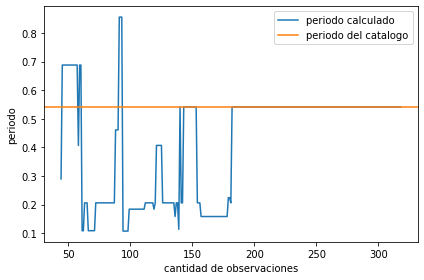

In [ ]:
plt.plot(size_list, period_list, color="tab:blue", label="periodo calculado")
plt.axhline(y=star.PeriodLS, color="tab:orange", label="periodo del catalogo")
plt.xlabel("cantidad de observaciones")
plt.ylabel("periodo")
plt.legend()
plt.tight_layout()
plt.show()

Eventualmente se estabiliza. Soy feliz. Aunque sinceramente no sé si se debe al monkeypatch o qué.

![code_works](code_works.png)